# Building a Decision Tree Classification Model Using CalFresh Data

## Decision Tree Classification Model to Predict Application Outcome (Approved/Denied)

I work at Alameda County Social Services in California. Social Services administers safety net programs which include CalFresh, previously known as Food Stamps. I will use CalFresh data from my work in order to try to build a model that predicts the outcome of an application using variables other than income. 

In this notebook, I will attempt to use scikit-learn to perform a decision tree based classification of application outcome data.

The first step is to query my work database for applications processed between Jan 1 2013 and Jul 31 2018. I queried a long period of time in order to get enough records to train and test the model.


    ## Research Question: Can we predict the outcome of an application (Approved/Denied) based on a set of indicators provided in the application?

## Importing the Necessary Libraries


In [4]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns

## Creating a Pandas DataFrame from the xlsx file

I queried my work's oracle database using a separate program and then exported the results to an xlsx file

We will first explore the dataset

In [5]:
data = pd.read_excel('FS_DATA.xlsx')

In [6]:
data.shape

(312633, 13)

## 312K records

My dataset includes 312K records and 13 columns, which should be enough to train and test my model.

In [7]:
data.columns

Index(['Index', 'REQ', 'ACT', 'DAYS', 'STS', 'STS_CD', 'TYP', 'LNG', 'SRC',
       'SX', 'ET', 'AGE', 'ZIP'],
      dtype='object')

Each row contains one application that has already been processed. Among other indicators, each row includes when the application was received, when it was processed, the days to process, the outcome (STS), and the indicators from the application.

Each row, or sample, consists of the following variables:

* **REQ:** request date aka application date
* **ACT:** date application was processed
* **DAYS:** days to process the application
* **STS:** outcome of the application as a category
* **STS_CD:** outcome of the application as a code
* **TYP:** type of application: new, reapplication
* **LNG:** language of applicant
* **SRC:** source of the application, how was the application received: mail, online, phone
* **SX:** applicant's sex
* **ET:** applicant's ethnicity
* **AGE:** applicant's age
* **ZIP:** applicant's zip

In [8]:
data.dtypes

Index              int64
REQ       datetime64[ns]
ACT       datetime64[ns]
DAYS               int64
STS               object
STS_CD             int64
TYP               object
LNG               object
SRC               object
SX                object
ET                object
AGE              float64
ZIP              float64
dtype: object

Our outcome variable is 'STS' and I have already converted this to an integer value in the column 'STS_CD' and assigned '1' to 'AP' aka Approved and '0' to 'DE' aka Denied.

5 of the indicators we need to build the model are currently in an object format and will need to be converted to a float in order to use them for our classification model. It is my understanding classificaiton models only take float/integer values and not strings.

I masked the application ID with an Index in order to maintain data confidentiality.

In [9]:
data.head(5)

,Index,REQ,ACT,DAYS,STS,STS_CD,TYP,LNG,SRC,SX,ET,AGE,ZIP
0,0,2013-06-14,2013-07-16,32,AP,1,RS,EN,WI,F,BL,25.3,94501.0
1,1,2013-11-22,2013-12-19,27,DE,0,RE,1T,WI,M,EH,27.9,94606.0
2,2,2013-12-16,2013-12-19,3,AP,1,RG,EN,BC,F,FI,42.2,94587.0
3,3,2013-11-04,2013-12-19,45,AP,1,RG,SP,WI,F,HM,42.9,94601.0
4,4,2013-05-07,2013-05-08,1,AP,1,RE,EN,WI,M,BL,49.2,99999.0


## Data Cleaning Steps

In [7]:
data[data.isnull().any(axis=1)]

,Index,REQ,ACT,DAYS,STS,STS_CD,TYP,LNG,SRC,SX,ET,AGE,ZIP
75596,32963,2013-07-24,2013-08-01,8,AP,1,IC,SP,WI,F,HI,25.8,NaN


Now let's drop null values using the *pandas dropna* function. 

In [22]:
before_rows = data.shape[0]
print(before_rows)

312633


In [23]:
data = data.dropna()

In [24]:
after_rows = data.shape[0]
print(after_rows)

312632


## How many rows dropped due to cleaning?

Most of the data was cleaned at the extraction phase so there are almost no nulls. Also, all of these indicators in an application are required fields so there shouldn't be nulls.

In [25]:
before_rows - after_rows

1

# DATA EXPLORATION

We will now look at the current dataset for exploratory purposes

In [11]:
data[['DAYS','AGE']].describe()

,DAYS,AGE
count,312633.000000,312633.000000
mean,15.123848,37.215855
std,18.744556,14.574875
min,0.000000,-0.300000
25%,1.000000,25.800000
50%,8.000000,33.400000
75%,28.000000,46.400000
max,149.000000,142.000000


Above are some stats about two of the float values we will use in our model. DAYS is days to process and we can see the minimum was 0 days (processed same day as the application date) and the max was 149 days. The average was 15 days with a standard deviation of 18.7.

For Age, the average age is 37.2 years old with a standard deviation of 14.5 years. The minimum was -0.3 which seems to be an error and the max was 142, which also seems to be an error. We will need to remove those from the dataset.

Text(0.5, 1.0, 'Count by Outcome')

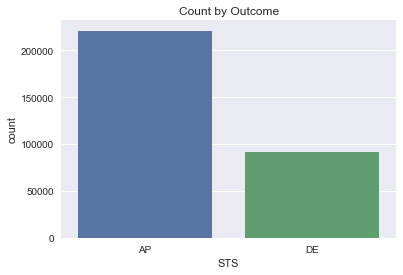

In [12]:
sns.set()
sns.countplot(data['STS']).set_title('Count by Outcome')

## This is the outcome I want to predict using a machine learning model

More applications were approved (over 200K) than denied (less than 100K).

Text(0.5, 1.0, 'Count by Application Type')

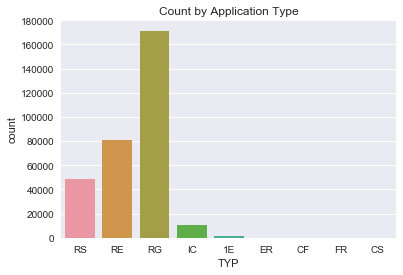

In [13]:
sns.countplot(data['TYP']).set_title('Count by Application Type')

The majority of applications were 'RG' Regular applications folloed by 'RE' Reapplication and 'RS' Restoration.

Text(0.5, 1.0, 'Count by Language')

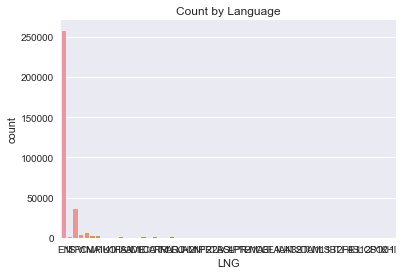

In [14]:
sns.countplot(data['LNG']).set_title('Count by Language')

seaborn produced a bar for all the values which makes it impossible to read so I'll switch back to matplot lib in order to set the top 10 by count. I wasn't able to figure out how to plot only the top 10 values in seaborn.

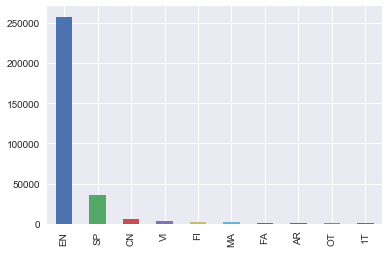

In [15]:
lang = data['LNG']
lang.value_counts()[:10].plot(kind='bar')
plt.show()

The majority of applicant's spoke English 'EN' followed by Spanish 'SP' followed by Cantonese 'CN'.

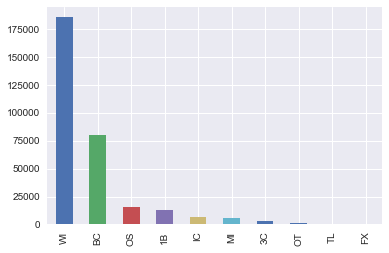

In [16]:
src = data['SRC']
src.value_counts()[:10].plot(kind='bar')

Above are the counts by application source showing Walk-Ins 'WI' as the most common, followed by 'BC' an online portal.

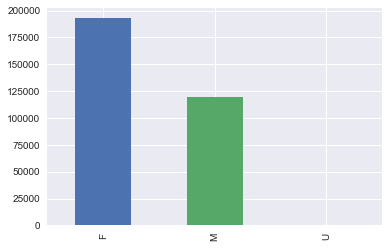

In [17]:
sx = data['SX']
sx.value_counts().plot(kind='bar')


More applicant's were female 'F' (close to 200K) than male 'M' (less than 125K). 

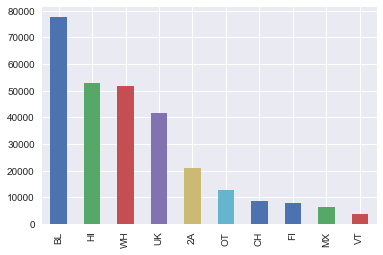

In [18]:
et = data['ET']
et.value_counts()[:10].plot(kind='bar')

Above is a count of applicant's by ethnicity code.

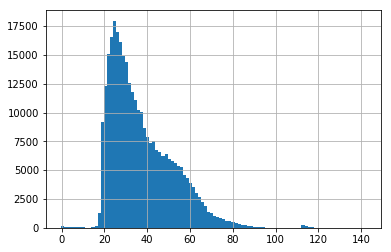

In [34]:
hist = data['AGE'].hist(bins=100)

Above is a histogram showing the age distribution of the primary applicant. Most applicants were between 20 and 50 years old.

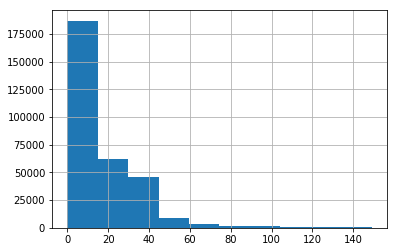

In [39]:
days = data['DAYS'].hist(bins=10)

Above is a histogram showing the distribution of days to process an application. Most were processed in under 40 days.

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold">
Convert to a Classification Task <br><br></p>
Binarize the relative_humidity_3pm to 0 or 1.<br>


# Converting object/string indicators to numerical values

### I will now attempt to convert the categorical values to numerical values since decision tree models require numerical values to run

In [12]:
df = data.copy()

In [26]:
df.columns

Index(['Index', 'REQ', 'ACT', 'DAYS', 'STS', 'STS_CD', 'TYP', 'LNG', 'SRC',
       'SX', 'ET', 'AGE', 'ZIP'],
      dtype='object')

In [27]:
df.dtypes

Index              int64
REQ       datetime64[ns]
ACT       datetime64[ns]
DAYS               int64
STS               object
STS_CD             int64
TYP                 int8
LNG                 int8
SRC                 int8
SX                  int8
ET                  int8
AGE              float64
ZIP              float64
dtype: object

## First I will convert object types to category types using the 'astype'

In [16]:
df['TYP'] = df['TYP'].astype('category')
df['LNG'] = df['LNG'].astype('category')
df['SRC'] = df['SRC'].astype('category')
df['SX'] = df['SX'].astype('category')
df['ET'] = df['ET'].astype('category')

In [17]:
df.head()

,Index,REQ,ACT,DAYS,STS,STS_CD,TYP,LNG,SRC,SX,ET,AGE,ZIP
0,0,2013-06-14,2013-07-16,32,AP,1,RS,EN,WI,F,BL,25.3,94501.0
1,1,2013-11-22,2013-12-19,27,DE,0,RE,1T,WI,M,EH,27.9,94606.0
2,2,2013-12-16,2013-12-19,3,AP,1,RG,EN,BC,F,FI,42.2,94587.0
3,3,2013-11-04,2013-12-19,45,AP,1,RG,SP,WI,F,HM,42.9,94601.0
4,4,2013-05-07,2013-05-08,1,AP,1,RE,EN,WI,M,BL,49.2,99999.0


In [18]:
df.dtypes

Index              int64
REQ       datetime64[ns]
ACT       datetime64[ns]
DAYS               int64
STS               object
STS_CD             int64
TYP             category
LNG             category
SRC             category
SX              category
ET              category
AGE              float64
ZIP              float64
dtype: object

The object datatypes were converted successfully to category types

## Next we will convert the category values to codes using cat.codes

In [19]:
df['TYP'] = df['TYP'].cat.codes
df['LNG'] = df['LNG'].cat.codes
df['SRC'] = df['SRC'].cat.codes
df['SX'] = df['SX'].cat.codes
df['ET'] = df['ET'].cat.codes


In [28]:
df.head()

,Index,REQ,ACT,DAYS,STS,STS_CD,TYP,LNG,SRC,SX,ET,AGE,ZIP
0,0,2013-06-14,2013-07-16,32,AP,1,8,33,34,0,33,25.3,94501.0
1,1,2013-11-22,2013-12-19,27,DE,0,6,11,34,1,38,27.9,94606.0
2,2,2013-12-16,2013-12-19,3,AP,1,7,33,17,0,39,42.2,94587.0
3,3,2013-11-04,2013-12-19,45,AP,1,7,54,34,0,43,42.9,94601.0
4,4,2013-05-07,2013-05-08,1,AP,1,6,33,34,1,33,49.2,99999.0


In [20]:
df.dtypes

Index              int64
REQ       datetime64[ns]
ACT       datetime64[ns]
DAYS               int64
STS               object
STS_CD             int64
TYP                 int8
LNG                 int8
SRC                 int8
SX                  int8
ET                  int8
AGE              float64
ZIP              float64
dtype: object

The category datatypes have successfully converted to int8 datatypes

In [30]:
#df['ZIP'] = df['ZIP'].astype('int64')

## I previusly converted the outcome status (Approved/Denied) to 0 or 1

In [26]:
df['STS_CD'].head()

0    1
1    0
2    1
3    1
4    1
Name: STS_CD, dtype: int64

# I will store the Target in 'y' 

My target is the outcome of the application: Approved is 1 and Denied is 0

In [27]:
y=df[['STS_CD']].copy()
#y

In [28]:
y.head()

,STS_CD
0,1
1,0
2,1
3,1
4,1


## Now that I have converted all categorical values to numerical values I can set the indicators to an object called 'indicators'. These will be used to build the model.

In [29]:
indicators = ['DAYS','TYP','LNG','SRC','SX','ET','AGE','ZIP']

In [30]:
X = df[indicators].copy()

In [31]:
X.columns
X.head()

,DAYS,TYP,LNG,SRC,SX,ET,AGE,ZIP
0,32,8,33,34,0,33,25.3,94501
1,27,6,11,34,1,38,27.9,94606
2,3,7,33,17,0,39,42.2,94587
3,45,7,54,34,0,43,42.9,94601
4,1,6,33,34,1,33,49.2,99999


In [32]:
y.columns

Index(['STS_CD'], dtype='object')



## We will now perform our Test and Train split



The test is '0.33' below means that 2/3 of the input data will be used to train the model and the test size will be 1/3 (0.33)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=324)

In [34]:
#type(X_train)
#type(X_test)
#type(y_train)
#type(y_test)
#X_train.head()
y_train.describe()

,STS_CD
count,209463.000000
mean,0.706387
std,0.455418
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


## Fit on Train Set

We will use the fit method of this object
to make the classifier tune itself
to learn from the samples.

## My model will be called 'outcome_classifier' since I am trying to predict the outcome of an applciation using specific indicators from the application.

In [35]:
outcome_classifier = DecisionTreeClassifier(max_leaf_nodes=10, random_state=0)
outcome_classifier.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=10,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [36]:
type(outcome_classifier)

sklearn.tree.tree.DecisionTreeClassifier

## Predict on Test Set 




In [37]:
predictions = outcome_classifier.predict(X_test)

In [38]:
predictions[:20]

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1],
      dtype=int64)

In [39]:
y_test['STS_CD'][:20]

169599    0
175382    0
115599    1
254289    1
291478    1
231041    1
5120      1
73255     1
230182    1
15180     1
55149     1
5817      1
134586    1
103405    1
170859    1
168284    0
31646     1
182646    1
1592      1
208028    0
Name: STS_CD, dtype: int64

## We will now measure the accuracy of the classifier


## The accuracy score for my model is 76.4% which isn't too bad.

In [40]:
accuracy_score(y_true = y_test, y_pred = predictions)

0.7641248824743867

# 76.4% accuracy score!!

#### My goal was to build a decision tree machine learning model that predictied the outcome of a CalFresh application using a set of specific indicators from the application. CalFresh is an income based safety net program and the goal was to build a model that used indicators other than income to predict the outcome. 

#### While I was able to successfully extract a clean dataset and convert categorical values to numerical values, a lot more work needs to be done in order to make this a succesful model. In building this model, I also read that having categorical values with too many possible values might cause a decision tree model to overfit the data. Some of my values had more than a few possible values so my model may be suffering from overfitting and that is something I wish to explore more as I advance through these data science classes.

#### Overall, I think this was a successful attempt to use what was taught in class to build my first machine learning model.

#### Thank you for reading!